In [20]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob

In [21]:

class NpyImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the .npy image files
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.transform = transform
        
        # Get all .npy files
        self.image_paths = []
        self.labels = []
        
        # Find all class directories
        class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

        print(class_dirs)
        self.class_to_idx = {class_name: i for i, class_name in enumerate(class_dirs)}
        
        # Collect all .npy files and their labels
        for class_name in class_dirs:
            class_path = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for file_path in glob.glob(os.path.join(class_path, '*.npy')):
                self.image_paths.append(file_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        label = self.labels[idx]
        
        image = torch.from_numpy(image).float()
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations (modify as needed)
transform = transforms.Compose([
        # def standardize(x, datatype, root):
        #     '''Standardize image examples'''
        #     # Make image contrast similar across all images
        #     x = ((x - np.mean(x, axis=(1, 2), keepdims=True)) /
        #         np.std(x, axis=(1, 2), keepdims=True))
        #     return x

        # ### Preprocess data ###

        # # Shuffle train data
        # perm = np.random.permutation(len(X_TRAIN))
        # X_TRAIN, Y_TRAIN = X_TRAIN[perm], Y_TRAIN[perm]

        # # Standardize data
        # X_TRAIN = standardize(X_TRAIN, 'train', OUTPATH)
        # X_VAL = standardize(X_VAL, 'val', OUTPATH)


])

dataset_train = NpyImageDataset(data_dir='/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/dataset/dataset/train', transform=transform)
dataset_val = NpyImageDataset(data_dir='/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/dataset/dataset/val', transform=transform)

batch_size = 32
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

#for train
print(f"Dataset size: {len(dataset_train)}")
print(f"Number of classes: {len(dataset_train.class_to_idx)}")
print(f"Class mapping: {dataset_train.class_to_idx}")

#for val
print(f"Dataset size: {len(dataset_val)}")
print(f"Number of classes: {len(dataset_val.class_to_idx)}")
print(f"Class mapping: {dataset_val.class_to_idx}")


['no', 'vort', 'sphere']
['no', 'vort', 'sphere']
Dataset size: 30000
Number of classes: 3
Class mapping: {'no': 0, 'vort': 1, 'sphere': 2}
Dataset size: 7500
Number of classes: 3
Class mapping: {'no': 0, 'vort': 1, 'sphere': 2}


Sample data shape: torch.Size([32, 1, 150, 150])
Sample label: 0


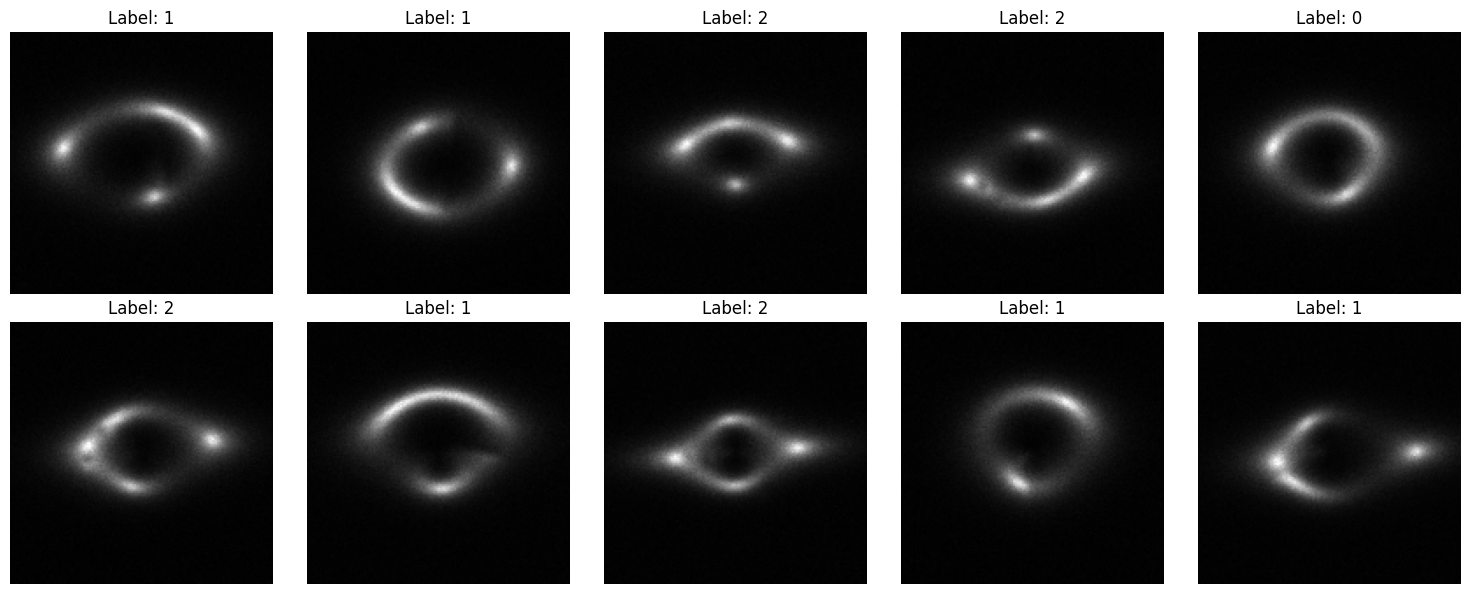

In [22]:
from torch.nn import functional as F
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

sample_data, sample_label = next(iter(train_loader))
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample label: {sample_label[0]}")

# plt.imshow(sample_data[0].squeeze(), cmap='gray')
# plt.title(f"Label: {sample_label[0]}")
# plt.show()

# plot 10 random sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    idx = np.random.randint(len(dataset_train))
    img, label = dataset_train[idx]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [23]:
import torch
import math

#trying out ViT
import torch.nn as nn

class PatchEmbed(nn.Module):
    """Split image into patches and embed them"""
    def __init__(self, img_size=150, patch_size=16, in_channels=1, embed_dim=768):
        super().__init__()
        self.img_size = (img_size, img_size) if isinstance(img_size, int) else img_size
        self.patch_size = (patch_size, patch_size) if isinstance(patch_size, int) else patch_size
        self.n_patches = (self.img_size[0] // self.patch_size[0]) * (self.img_size[1] // self.patch_size[1])
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=self.patch_size, stride=self.patch_size)
        
    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H, W)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, input_channels=1, img_size=150, patch_size=16, embed_dim=384, 
                 depth=8, num_heads=6, mlp_ratio=4., drop_rate=0.2, num_classes=3):
        super().__init__()
        
        #adjusting img_size based on the actual input size from sample_data
        self.img_size = sample_data.shape[2]
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, 
            in_channels=input_channels, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches
        
        #adding class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        #transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,
                qkv_bias=True, drop=drop_rate, attn_drop=drop_rate)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):

        #cls token
        nn.init.normal_(self.cls_token, std=.02)
        nn.init.normal_(self.pos_embed, std=.02)
        
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        # Add cls token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        # Use cls token for classification
        x = x[:, 0]
        x = self.head(x)
        return x


In [24]:
import torch

import torch.nn as nn
import torchvision.models as models

input_channels = sample_data.shape[1]

#ResNet18 model
resnet = models.resnet18(pretrained=False)
resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Linear(512, 3)

# #DenseNet model
# densenet = models.densenet121(pretrained=False)
# densenet.features.conv0 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
# densenet.classifier = nn.Linear(densenet.classifier.in_features, 3)

# #a simple ensemble model
# class EnsembleModel(nn.Module):
#     def __init__(self, modelA, modelB, num_classes=3):
#         super(EnsembleModel, self).__init__()
#         self.modelA = modelA
#         self.modelB = modelB
#         self.fc = nn.Linear(3 * 2, num_classes)  # Combining outputs from both models

#     def forward(self, x):
#         x1 = self.modelA(x)
#         x2 = self.modelB(x)
#         x = torch.cat((x1, x2), dim=1)
#         x = self.fc(x)
#         return x

# model = EnsembleModel(resnet, densenet)

model = resnet
print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  #starting with  a lower learning rate

print(f"Input channels: {input_channels}")
print(f"Sample data shape: {sample_data.shape}")
print(f"Number of classes: {len(dataset_train.class_to_idx)}")

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/vimarsh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vimarsh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [25]:
# import torchvision.models as models
# model = models.resnet18(pretrained=True)
# model = vision_transformer.ViT('B_16', pretrained=True)
# model.fc = nn.Linear(512, 3)
#using model from

In [26]:

# Initialize model with proper input channels
input_channels = sample_data.shape[1]
# model = LensingCNN(input_channels)
# model = VisionTransformer(input_channels=input_channels)
# model.fc = nn.Linear(512, 3)

print(model)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = "cpu"
    print(f"Using device: {device}")
    model.to(device)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [28]:
def evaluate_model(model, val_loader, num_classes=3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    #for all classes
    for i in range(num_classes):
        y_true = (all_labels == i).astype(int)
        y_score = all_probs[:, i]
        
        fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Micro-average calc
    y_true_flat = np.eye(num_classes)[all_labels].ravel()
    y_score_flat = all_probs.ravel()
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_flat, y_score_flat)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    #Plotting ROC curves
    plt.figure(figsize=(10, 8))
    
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle='-', linewidth=2)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    class_names = ['No Substructure', 'Vortex Substructure', 'Subhalo Substructure']
    
    for i, color, class_name in zip(range(num_classes), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, linestyle='-', linewidth=2,
                 label=f'ROC for {class_name} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return fpr, tpr, roc_auc


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

num_epochs = 300 
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs)

#save model
torch.save(model.state_dict(), 'classifier_resnet_300.pth')


Using device: cuda:0


Epoch 1/300, Train Loss: 1.1191, Train Acc: 33.46%, Val Loss: 1.1167, Val Acc: 33.99%
Epoch 2/300, Train Loss: 1.1087, Train Acc: 32.85%, Val Loss: 1.0984, Val Acc: 34.11%
Epoch 3/300, Train Loss: 1.1070, Train Acc: 33.30%, Val Loss: 1.1045, Val Acc: 33.32%
Epoch 4/300, Train Loss: 1.1040, Train Acc: 33.40%, Val Loss: 1.1051, Val Acc: 33.36%
Epoch 5/300, Train Loss: 1.1048, Train Acc: 33.47%, Val Loss: 1.1208, Val Acc: 33.35%
Epoch 6/300, Train Loss: 1.1023, Train Acc: 33.76%, Val Loss: 1.1012, Val Acc: 33.17%
Epoch 7/300, Train Loss: 1.1013, Train Acc: 33.79%, Val Loss: 1.0997, Val Acc: 33.05%
Epoch 8/300, Train Loss: 1.1008, Train Acc: 33.65%, Val Loss: 1.0996, Val Acc: 33.36%
Epoch 9/300, Train Loss: 1.1007, Train Acc: 33.94%, Val Loss: 1.0999, Val Acc: 33.64%
Epoch 10/300, Train Loss: 1.0985, Train Acc: 34.48%, Val Loss: 1.1018, Val Acc: 33.60%
Epoch 11/300, Train Loss: 1.0981, Train Acc: 34.58%, Val Loss: 1.0992, Val Acc: 34.73%
Epoch 12/300, Train Loss: 1.0310, Train Acc: 42.74%,

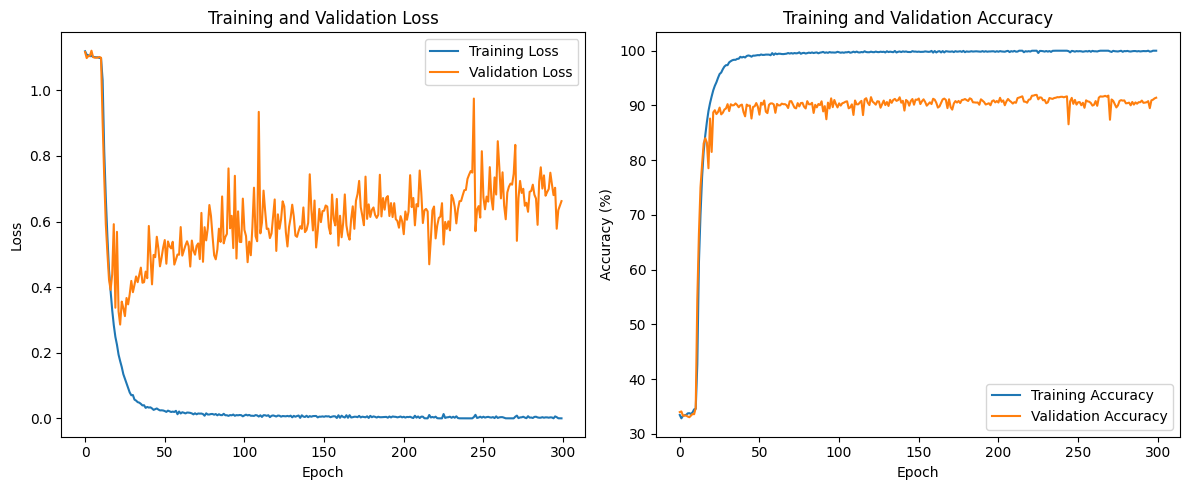

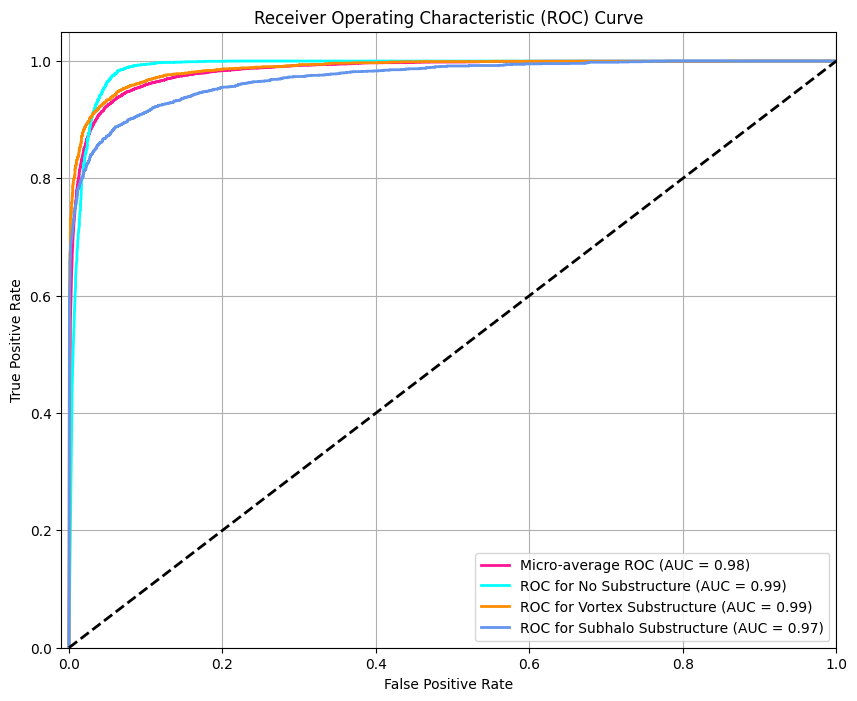

In [30]:
#plotting metrics

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()

fpr, tpr, roc_auc = evaluate_model(model, val_loader, num_classes=3)

In [31]:
#print auc score
print(f"AUC Score: {roc_auc['micro']}")

AUC Score: 0.9838126488888888
